## Importing Libraries

In [1]:
#!/usr/bin/env python3
# import libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import import_ipynb


## Preprocessing Class

In [2]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        self._correct_nan_value() #testing commenting out 
        for val in self.df_train.columns:
            total_null = np.sum(self.df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(self.df_train[val].dtype)
                self.list_unique_total.append(len(self.df_train[val].unique()))
                self.list_unique_val.append(self.df_train[val].unique())
                self.list_mode_value.append(self.df_train[val].mode()[0])
                val_counts = max(self.df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(self.df_train))
                val_unique = self.df_train[val].unique()
                self._create_dict(val_unique, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _correct_nan_value(self):
        '''correcting nan string values by converting to np.nan'''
        for col in self.df_train.columns:
            val_total_nan = self.df_train[self.df_train[col]=='nan']
            val_total_nan = val_total_nan.shape[0]
            if val_total_nan > 0:
                index_nan = self.df_train[self.df_train[col]=='nan']
                index_nan = index_nan.index 
                self.df_train.loc[index_nan, col] = np.nan
                
    def _create_dict(self, val_unique, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(self.df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(self.df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, 
                         self.list_unique_total,self.list_mode_value, 
                         self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv(filepath_files + 'df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                if val == 'P_emaildomain':
                    self.df_train[val] = self.df_train[val].fillna('missing')
                else:
                    val_mode = self.df_train[val].mode()[0]
                    self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

## Model Class

In [3]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}

    def create_df_score_model(self, model):
        '''scores model'''
        print("\nThe following model is being fitted:\n") 
        print(model)
        y_pred, elapsed_time, model = self.add_model(model) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred, model = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time, model
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred, model = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred, model
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred, model
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob, model
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('\nBelow are the results by threshold:\n')
        print(df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = val_cost_fn*val_fn + val_cost_fp*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        print('\nThe plot below shows the threshold by auc roc score.\n')
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        print('The plot below shows the cost by threshold based')
        print('upon the cost of false positive and false negatives.\n')
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc)
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time, col_auc = self._calc_scores(y_pred, 
                                                                         elapsed_time) 
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_auc, col_recall, col_precision, 
                             df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_auc = pd.Series(roc_auc_score(mod.y_test, y_pred), name='roc_auc_score')
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nThe best threshold has been automatically selected and scored below.')
        print('roc auc score:', roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time, col_auc
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:")
        print(fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv(filepath_files + 'df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv(filepath_files + 'df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print('\nThe classification report for the current model is shown below.\n')
        print(classif_report)
        print('\nThe last row in the dataframe represents the results of the current model.\n')
        print(df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open(filepath_files + 'df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            self._feat_import_method(model)
        except:
            print("\nThis model does not have the _feature_importance attribute.")
    
    def _feat_import_method(self, model):
        '''run feature importance methods'''
        df_feat_rank = self._feat_import_create_df(model)
        df_feat_rank = self._feat_import_create_plot(df_feat_rank)
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(mod.X_train.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank.reset_index(drop=True)
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        print("\nThe bar chart represents the list of important features in this model.\n")
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        print('\nThe dataframe represents the top 20 features for this model.\n')
        print(df_feat_rank[0:20])

## Feature Engineering Class

In [4]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns:')
        print(self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current = LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._sampling_techniques(X_train, y_train)
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        
    def _sampling_techniques(self, X_train, y_train):
        '''applying resampling techniques and shuffle'''
        X_train, y_train = self._apply_downsampling(X_train, y_train)
        X_train, y_train = self._apply_smote(X_train, y_train)
        X_train, y_train = self._shuffle_df(X_train, y_train)
        return X_train, y_train
    
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            X_col_names = X.columns
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            X_col_names = X.columns
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
        
    def _apply_col_names(self, X, X_col_names):
        '''adding column names back to dataset'''
        X = pd.DataFrame(X, columns=X_col_names)
        return X
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if col in df_features.columns:    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        '''aggregate potential new futures for a later time'''
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if non_fraud_total==0:
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

#### Reading files and merging dataframe

In [5]:
filepath_data = '/Users/krahman/work/fraud_detection/data/'
filepath_files = '/Users/krahman/work/fraud_detection/saved_files/'
train_transaction = pd.read_csv(filepath_data + 'train_transaction.csv')
train_identity = pd.read_csv(filepath_data + 'train_identity.csv')
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

#### Dropping columns with more than 50% missing data

In [6]:
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

#### Grouping columns into lists

In [7]:
# c is numerical. how many addresses associated with card
col_c = [c for c in df_train.columns 
         if c.startswith('C') and (len(c) == 2 or len(c) == 3)]
# d is numerical, time/days between transactions
col_d = [d for d in df_train.columns 
         if d.startswith('D') and (len(d) == 2 or len(d) == 3)]
# m is date of transaction
col_m = [m for m in df_train.columns 
         if m.startswith('M') and (len(m) == 2 or len(m) == 3)]
# v is numerical, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns 
         if v.startswith('V') and (len(v) == 2 or len(v) == 3 or len(v) == 4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns 
         if i.startswith('id_') and len(i) == 5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns 
            if ca.startswith('card')]

#### Setting column id and target

In [8]:
col_id = ['TransactionID']
col_target = 'isFraud'

#### Converting categorical columns with numerical values to object types.

In [9]:
col_cat_to_obj = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

col_cat = ['addr1', 'addr2', 'ProductCD', 'P_emaildomain'] + col_card + col_m

#### Grouping numerical columns

In [10]:
#### C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

#### Setting date column

In [11]:
col_date = ['TransactionDT'] 

#### Total columns

In [12]:
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


#### Instantiating Preprocessing object

In [13]:
pp = Preprocessing()

#### Instantiating Model object

In [14]:
mod = Model()

#### Instantiating Feature Engineering object

In [15]:
# fe = FeatureEngineering()

#### Creating null dataframe

In [16]:
df_null_info = pp.missing_values()

There were 200 columns with null values.


#### Imputing features and saving to csv file

In [17]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv(filepath_files + 'df_imputed.csv')

label encoded: addr1 unique 332
label encoded: addr2 unique 74
dummies encoded: ProductCD unique 5
label encoded: P_emaildomain unique 60
label encoded: card1 unique 13553
label encoded: card2 unique 500
label encoded: card3 unique 114
dummies encoded: card4 unique 4
label encoded: card5 unique 119
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 228)


#### Reading preprocessed dataframe

In [18]:
df_features = pd.read_csv(filepath_files + 'df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

#### Instantiating Feature Engineering object

In [19]:
fe = FeatureEngineering()

#### Applying Principal Component Analysis

In [20]:
bool_apply_pca = False

#### Applying Upsampling

In [21]:
bool_apply_smote = True

#### Applying Downsampling

In [22]:
bool_apply_downsampling = True

#### Apply Predict Proba Method

In [23]:
bool_predict_proba = False

#### Create Tuning Dataframe

In [24]:
bool_create_tuning_df = True

In [25]:
# bool_predict_proba = False
# bool_thres_cost = False
# bool_apply_pca = False
# bool_apply_smote = True
# bool_apply_downsampling = True
# bool_create_tuning_df = True
# df_feat_1000 = False # this is for shortening the dataset for quick debugging

##### Turn on Predict Proba Threshold by Cost

In [26]:
bool_thres_cost = False

#### Set the cost of false positives/false negatives

In [27]:
val_cost_fn = 3000
val_cost_fp = 20

##### Limit Training Set To 1000 Rows For Debugging

In [28]:
df_feat_1000 = False

#### Creating features (feature engineering)

In [29]:
bool_drop_col = True # dropping original features used to create new features
fe.final_features(bool_drop_col, list_feat=['addr1', 'addr2', 'card2', 
                                            'card3', 'C1', 'P_emaildomain', 
                                            'card6', 'V294', 'V279', 'C14', 
                                            'V306', 'D2', 'D10'])

bool_drop_col = False # keeping original features used to create new features
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 
                                            'D1', 'D3', 'D4', 'D11'])

after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11


#### Appending C4 to list of features to drop

In [30]:
fe.list_drop_col.append('C4')

#### Dropping columns, applying dataframe transformations, creating training and test dataframe

In [31]:
fe.create_final_df()

dropping columns:
['addr1', 'addr2', 'card2', 'card3', 'C1', 'P_emaildomain', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current = LogisticRegression().


#### Commenting out - this is used to test features individually

In [32]:
# df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# fe.create_final_df()
# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

#### RandomForestclassifier Results


The following model is being fitted:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

The plot below shows the threshold by auc roc score.



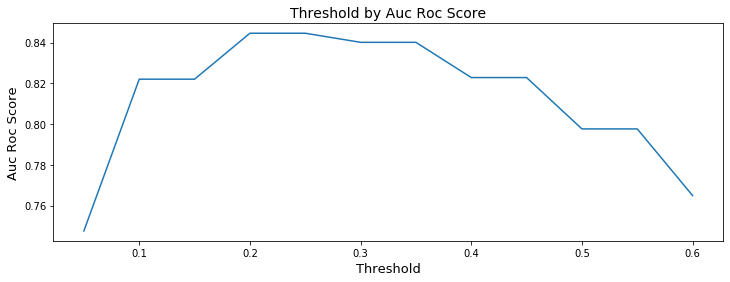

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



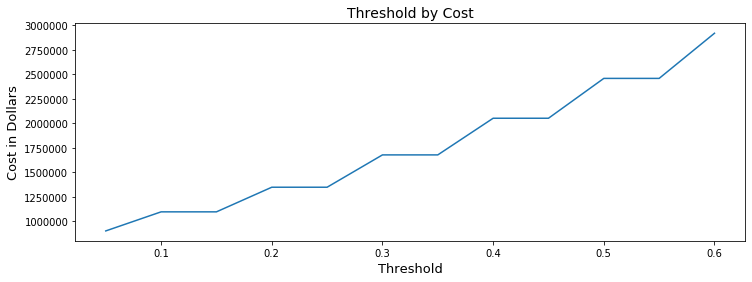

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.747606      902080  133  25154
1        0.10       0.822028     1096640  281  12682
2        0.15       0.822028     1096640  281  12682
3        0.20       0.844566     1347880  404   6794
4        0.25       0.844566     1347880  404   6794
5        0.30       0.840113     1677820  534   3791
6        0.35       0.840113     1677820  534   3791
7        0.40       0.822823     2051760  670   2088
8        0.45       0.822823     2051760  670   2088
9        0.50       0.797640     2458440  812   1122
10       0.55       0.797640     2458440  812   1122
11       0.60       0.764932     2919160  969    608

The best threshold has been automatically selected and scored below.
roc auc score: 0.8445659573275787

The following new features have been created:
['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe'

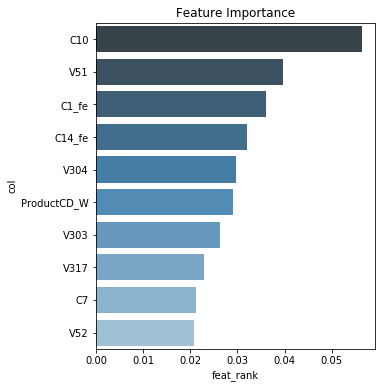


The dataframe represents the top 20 features for this model.

               col  feat_rank
0              C10   0.056354
1              V51   0.039622
2            C1_fe   0.036111
3           C14_fe   0.032052
4             V304   0.029754
5      ProductCD_W   0.029034
6             V303   0.026251
7             V317   0.022822
8               C7   0.021318
9              V52   0.020689
10            V102   0.020489
11             V93   0.019687
12        card2_fe   0.019487
13             C11   0.017514
14   TransactionDT   0.016639
15  TransactionAmt   0.015904
16            V302   0.015700
17     card6_debit   0.014639
18             C13   0.013675
19             V30   0.012862


In [33]:
# BASE 0.8463 RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)

In [34]:
# # BASE 0.8463 RandomForestClassifier
# bool_predict_proba = True
# model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
# mod.create_df_score_model(model_current)


The following model is being fitted:


The plot below shows the threshold by auc roc score.



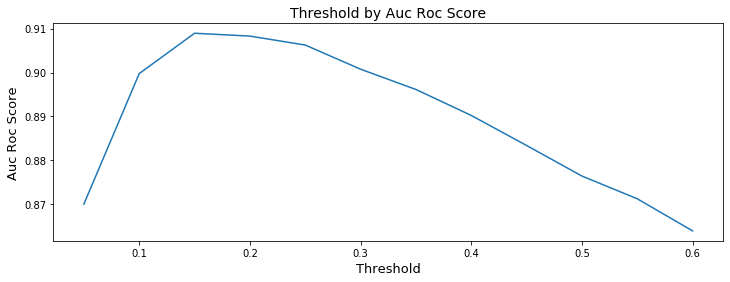

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



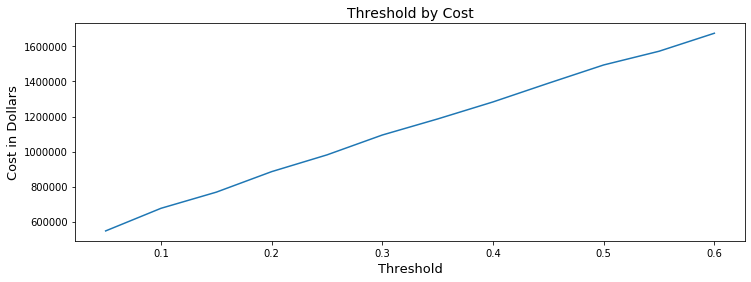

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.870023      546980  102  12049
1        0.10       0.899761      676040  182   6502
2        0.15       0.908954      768260  228   4213
3        0.20       0.908304      885360  275   3018
4        0.25       0.906267      981020  312   2251
5        0.30       0.900761     1094420  353   1771
6        0.35       0.896142     1186120  386   1406
7        0.40       0.890224     1283240  420   1162
8        0.45       0.883375     1389860  457    943
9        0.50       0.876412     1494280  493    764
10       0.55       0.871231     1572500  520    625
11       0.60       0.863908     1675280  555    514

The best threshold has been automatically selected and scored below.
roc auc score: 0.9089541117199385
The classification report for the current model is shown below.

              precision    recall  f1

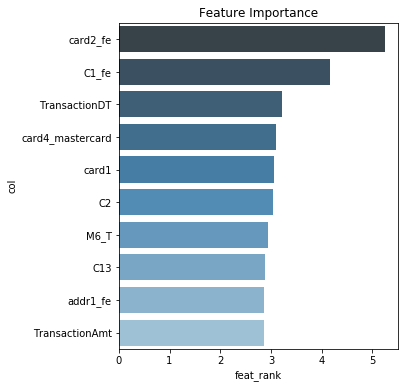


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0           card2_fe   5.239115
1              C1_fe   4.158335
2      TransactionDT   3.224506
3   card4_mastercard   3.104528
4              card1   3.052050
5                 C2   3.043723
6               M6_T   2.949351
7                C13   2.874497
8           addr1_fe   2.871579
9     TransactionAmt   2.867627
10      card6_credit   2.630639
11            C14_fe   2.428476
12  P_emaildomain_fe   2.336464
13           V306_fe   2.261050
14           V294_fe   2.244380
15       card6_debit   1.728395
16           V279_fe   1.553797
17               V13   1.548483
18               V95   1.546687
19              V304   1.435341


In [35]:
# 0.9077
bool_predict_proba = True
model_current = CatBoostClassifier(
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

### Test Models


The following model is being fitted:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

The plot below shows the threshold by auc roc score.



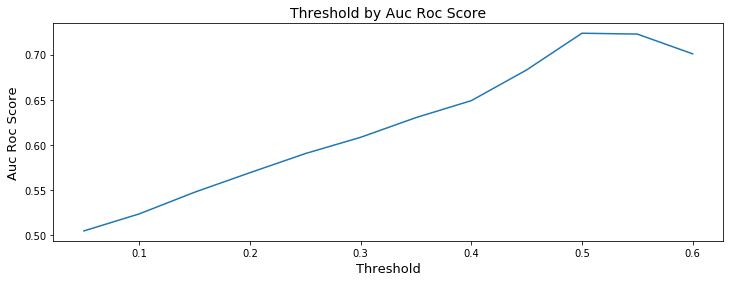

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



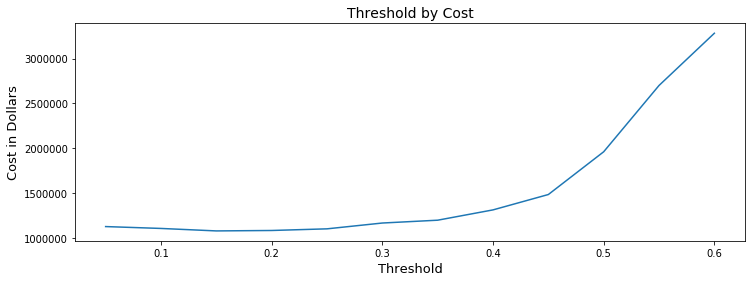

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.5

Below are the results by threshold:

    threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.504838     1130340     1  56367
1        0.10       0.523689     1109540    10  53977
2        0.15       0.547660     1082000    21  50950
3        0.20       0.569303     1086820    43  47891
4        0.25       0.590438     1105100    70  44755
5        0.30       0.608472     1169800   113  41540
6        0.35       0.630282     1201300   146  38165
7        0.40       0.649063     1315960   210  34298
8        0.45       0.683069     1486960   311  27698
9        0.50       0.723711     1962640   542  16832
10       0.55       0.722804     2700240   841   8862
11       0.60       0.700904     3281480  1057   5524

The best threshold has been automatically selected and scored below.
roc auc score: 0.7237113531682159
The classification report for the current model is shown below.

              precision  

In [36]:
# BASE LogisticRegression
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)


The following model is being fitted:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)

The plot below shows the threshold by auc roc score.



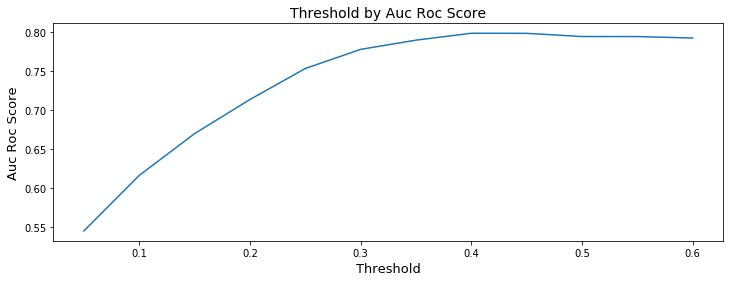

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



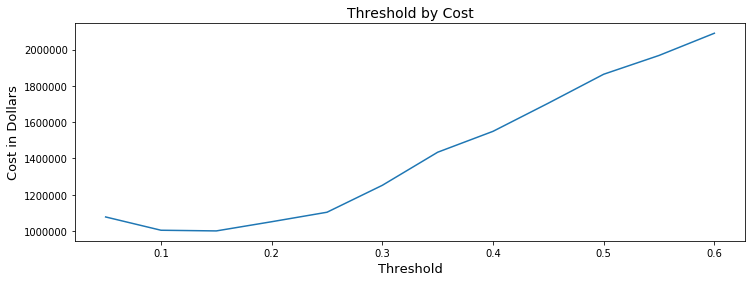

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.545149     1077880   17  51344
1        0.10       0.616164     1004680   53  42284
2        0.15       0.669637     1000960  101  34898
3        0.20       0.713283     1051600  162  28280
4        0.25       0.752979     1103860  220  22193
5        0.30       0.777476     1252240  303  17162
6        0.35       0.789267     1434480  388  13524
7        0.40       0.798135     1549580  443  11029
8        0.45       0.798020     1704820  506   9341
9        0.50       0.793946     1864160  567   8158
10       0.55       0.793875     1967640  609   7032
11       0.60       0.791996     2090000  657   5950

The best threshold has been automatically selected and scored below.
roc auc score: 0.7981348660609813
The classification report for the current model is shown below.

              precision    recall  f1-

In [37]:
# TUNED LogisticRegression
bool_predict_proba = True
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                    intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                                    multi_class='auto', n_jobs=-1, penalty='none',
                                    random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                    warm_start=False)

mod.create_df_score_model(model_current)



The following model is being fitted:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

The plot below shows the threshold by auc roc score.



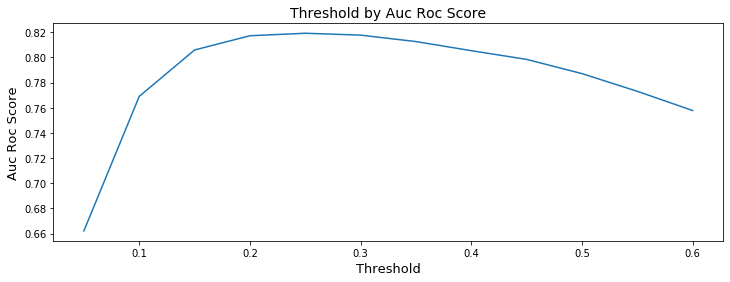

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



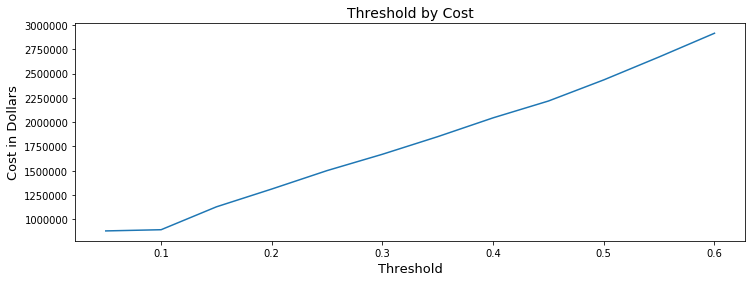

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.662130      880300   45  37265
1        0.10       0.769057      892580  149  22279
2        0.15       0.805916     1128420  279  14571
3        0.20       0.817242     1311720  364  10986
4        0.25       0.819234     1501520  443   8626
5        0.30       0.817741     1669740  510   6987
6        0.35       0.812621     1851140  579   5707
7        0.40       0.805386     2044740  651   4587
8        0.45       0.798457     2217960  715   3648
9        0.50       0.787174     2435540  793   2827
10       0.55       0.773090     2671800  876   2190
11       0.60       0.757829     2915660  961   1633

The best threshold has been automatically selected and scored below.
roc auc score: 0.819234172409212
The classification report for the current model is shown below.

              precision    recall  f1-

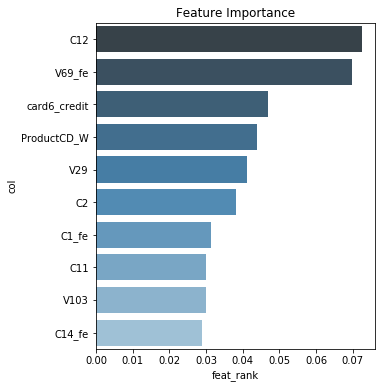


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0                C12   0.072425
1             V69_fe   0.069921
2       card6_credit   0.047008
3        ProductCD_W   0.043823
4                V29   0.041301
5                 C2   0.038276
6              C1_fe   0.031356
7                C11   0.029979
8               V103   0.029896
9             C14_fe   0.028987
10           V317_fe   0.025630
11                C6   0.024823
12               V97   0.024282
13          card2_fe   0.022373
14              V102   0.022326
15               V90   0.021316
16               V34   0.020517
17        card4_visa   0.020478
18  card4_mastercard   0.019181
19           V294_fe   0.018210


In [38]:
# BASE XGBClassifier
bool_predict_proba = True
model_current = XGBClassifier(n_jobs=-1,random_state=42)
mod.create_df_score_model(model_current)


The following model is being fitted:

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)

The plot below shows the threshold by auc roc score.



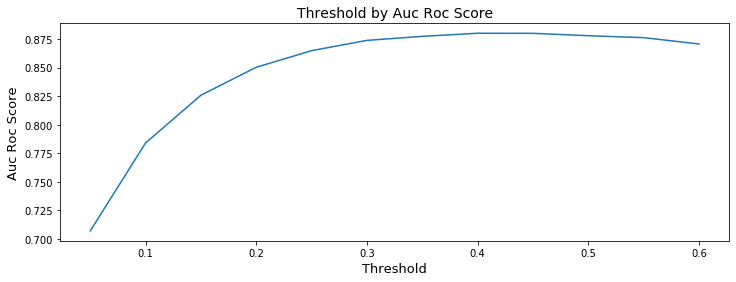

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



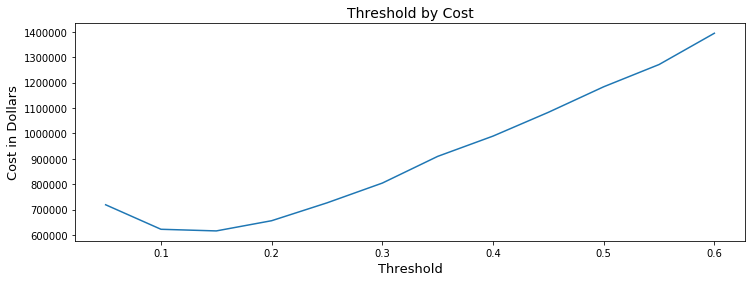

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.707138      718740   21  32787
1        0.10       0.784098      622160   53  23158
2        0.15       0.825805      615720   89  17436
3        0.20       0.850267      655940  128  13597
4        0.25       0.864754      726260  170  10813
5        0.30       0.873754      804160  210   8708
6        0.35       0.877274      909300  256   7065
7        0.40       0.879996      989200  291   5810
8        0.45       0.879916     1082860  329   4793
9        0.50       0.877853     1183500  368   3975
10       0.55       0.876140     1271040  402   3252
11       0.60       0.870608     1394340  447   2667

The best threshold has been automatically selected and scored below.
roc auc score: 0.8799958208782975
The classification report for the current model is shown below.

              precision    recall  f1-

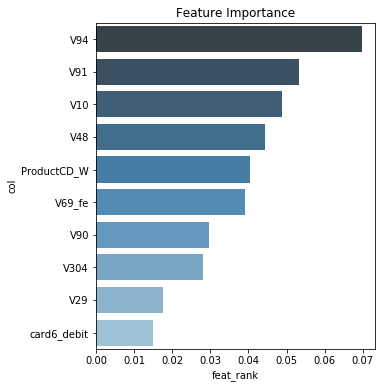


The dataframe represents the top 20 features for this model.

            col  feat_rank
0           V94   0.069695
1           V91   0.053182
2           V10   0.048703
3           V48   0.044470
4   ProductCD_W   0.040502
5        V69_fe   0.039184
6           V90   0.029616
7          V304   0.027991
8           V29   0.017509
9   card6_debit   0.014837
10          V34   0.014738
11         V303   0.012653
12          V70   0.012640
13         V302   0.012560
14     card6_fe   0.010502
15       C14_fe   0.010253
16      V317_fe   0.009963
17          C11   0.009923
18         V280   0.009041
19      V294_fe   0.009016


In [39]:
# TUNED XGBClassifier n_estimators=150
bool_predict_proba = True
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)


The following model is being fitted:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

The plot below shows the threshold by auc roc score.



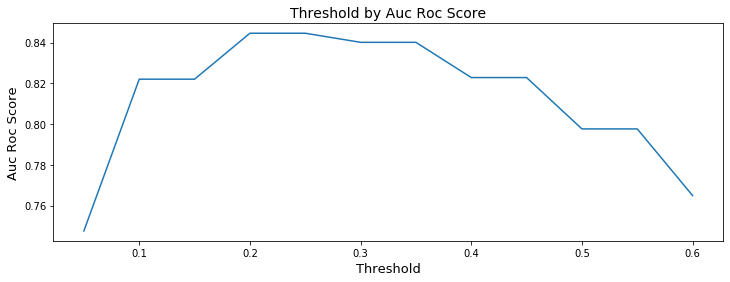

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



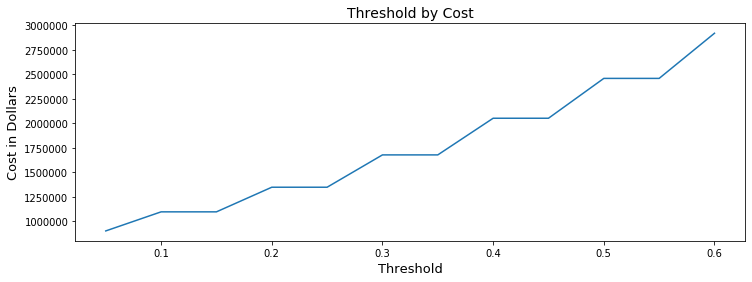

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.747606      902080  133  25154
1        0.10       0.822028     1096640  281  12682
2        0.15       0.822028     1096640  281  12682
3        0.20       0.844566     1347880  404   6794
4        0.25       0.844566     1347880  404   6794
5        0.30       0.840113     1677820  534   3791
6        0.35       0.840113     1677820  534   3791
7        0.40       0.822823     2051760  670   2088
8        0.45       0.822823     2051760  670   2088
9        0.50       0.797640     2458440  812   1122
10       0.55       0.797640     2458440  812   1122
11       0.60       0.764932     2919160  969    608

The best threshold has been automatically selected and scored below.
roc auc score: 0.8445659573275787
The classification report for the current model is shown below.

              precision    recall  f1-

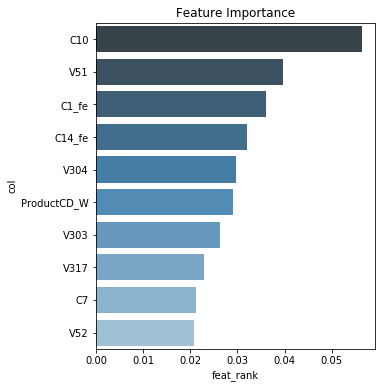


The dataframe represents the top 20 features for this model.

               col  feat_rank
0              C10   0.056354
1              V51   0.039622
2            C1_fe   0.036111
3           C14_fe   0.032052
4             V304   0.029754
5      ProductCD_W   0.029034
6             V303   0.026251
7             V317   0.022822
8               C7   0.021318
9              V52   0.020689
10            V102   0.020489
11             V93   0.019687
12        card2_fe   0.019487
13             C11   0.017514
14   TransactionDT   0.016639
15  TransactionAmt   0.015904
16            V302   0.015700
17     card6_debit   0.014639
18             C13   0.013675
19             V30   0.012862


In [40]:
# BASE 0.8463 RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)



The following model is being fitted:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.3s finished



The plot below shows the threshold by auc roc score.



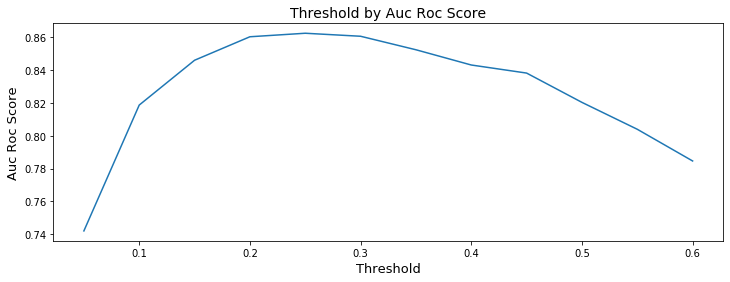

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



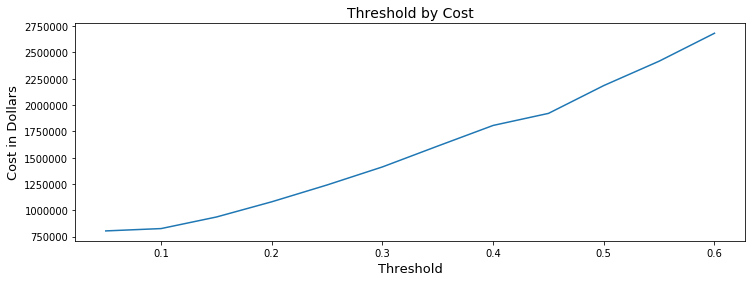

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.742005      804140   88  27007
1        0.10       0.818639      826380  168  16119
2        0.15       0.845928      936420  238  11121
3        0.20       0.860231     1080960  310   7548
4        0.25       0.862373     1240900  377   5495
5        0.30       0.860537     1412360  445   3868
6        0.35       0.852318     1610660  518   2833
7        0.40       0.843037     1806460  589   1973
8        0.45       0.838119     1920980  631   1399
9        0.50       0.820277     2185480  722    974
10       0.55       0.803901     2417120  801    706
11       0.60       0.784592     2682500  891    475

The best threshold has been automatically selected and scored below.
roc auc score: 0.8623728376906651
The classification report for the current model is shown below.

              precision    recall  f1

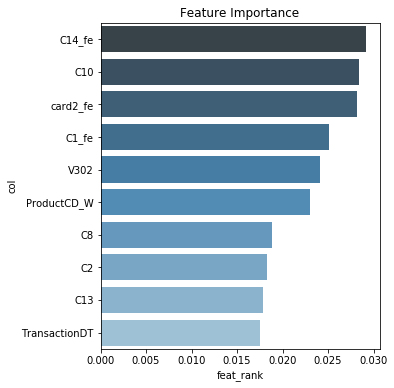


The dataframe represents the top 20 features for this model.

               col  feat_rank
0           C14_fe   0.029204
1              C10   0.028391
2         card2_fe   0.028177
3            C1_fe   0.025090
4             V302   0.024073
5      ProductCD_W   0.023058
6               C8   0.018839
7               C2   0.018287
8              C13   0.017801
9    TransactionDT   0.017513
10  TransactionAmt   0.016008
11            V317   0.015935
12         V317_fe   0.015492
13         V306_fe   0.014787
14     card6_debit   0.014353
15             C11   0.014117
16         V294_fe   0.013759
17            V303   0.013479
18        card3_fe   0.013096
19            V280   0.012003


In [41]:
# TUNED RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)

mod.create_df_score_model(model_current)



The following model is being fitted:


The plot below shows the threshold by auc roc score.



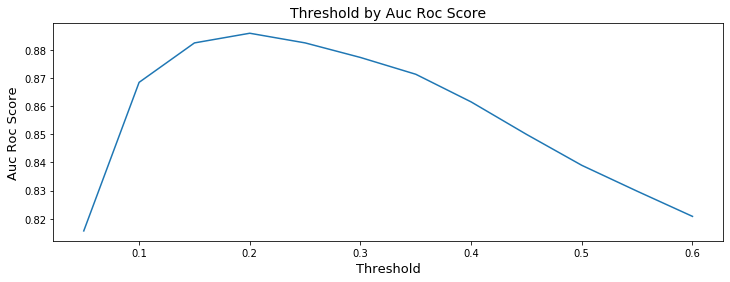

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



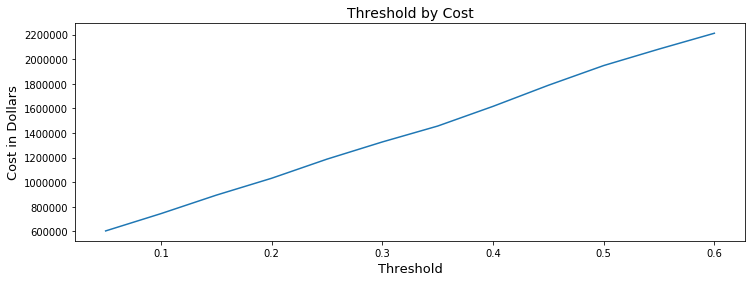

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.815690      604320   75  18966
1        0.10       0.868407      745000  181  10100
2        0.15       0.882402      895160  255   6508
3        0.20       0.885835     1032480  314   4524
4        0.25       0.882410     1187880  374   3294
5        0.30       0.877238     1327580  426   2479
6        0.35       0.871275     1456780  473   1889
7        0.40       0.861467     1616880  529   1494
8        0.45       0.849956     1788240  588   1212
9        0.50       0.838962     1948580  643    979
10       0.55       0.829786     2082640  689    782
11       0.60       0.820847     2211240  733    612

The best threshold has been automatically selected and scored below.
roc auc score: 0.8858345967911523
The classification report for the current model is shown below.

              precision    recall  f1-

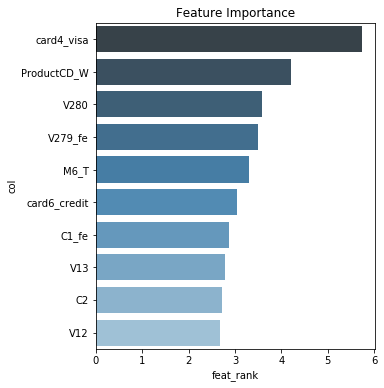


The dataframe represents the top 20 features for this model.

             col  feat_rank
0     card4_visa   5.728509
1    ProductCD_W   4.210270
2           V280   3.589747
3        V279_fe   3.486034
4           M6_T   3.298860
5   card6_credit   3.042406
6          C1_fe   2.877012
7            V13   2.772987
8             C2   2.713247
9            V12   2.678343
10           V95   2.658365
11      card2_fe   2.647013
12           V75   2.469073
13          V291   2.465392
14        C14_fe   2.461183
15          V308   2.378691
16           C13   2.316735
17          V128   2.118967
18   card6_debit   1.926653
19       V306_fe   1.891803


In [42]:
# BASE CatBoostClassifier 
bool_predict_proba = True
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)


The following model is being fitted:


The plot below shows the threshold by auc roc score.



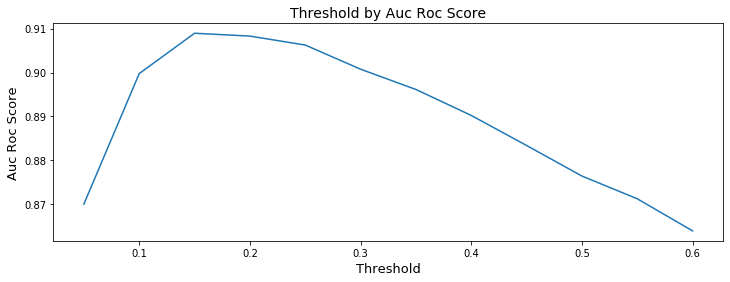

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



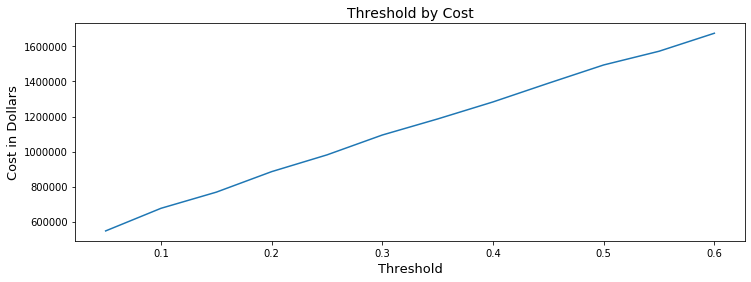

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.870023      546980  102  12049
1        0.10       0.899761      676040  182   6502
2        0.15       0.908954      768260  228   4213
3        0.20       0.908304      885360  275   3018
4        0.25       0.906267      981020  312   2251
5        0.30       0.900761     1094420  353   1771
6        0.35       0.896142     1186120  386   1406
7        0.40       0.890224     1283240  420   1162
8        0.45       0.883375     1389860  457    943
9        0.50       0.876412     1494280  493    764
10       0.55       0.871231     1572500  520    625
11       0.60       0.863908     1675280  555    514

The best threshold has been automatically selected and scored below.
roc auc score: 0.9089541117199385
The classification report for the current model is shown below.

              precision    recall  f1

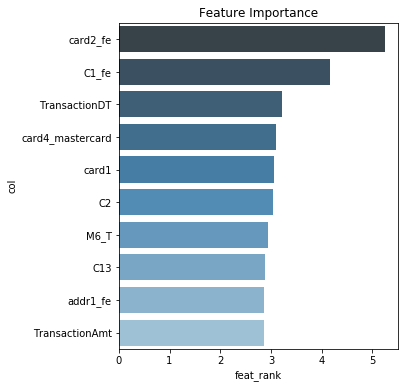


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0           card2_fe   5.239115
1              C1_fe   4.158335
2      TransactionDT   3.224506
3   card4_mastercard   3.104528
4              card1   3.052050
5                 C2   3.043723
6               M6_T   2.949351
7                C13   2.874497
8           addr1_fe   2.871579
9     TransactionAmt   2.867627
10      card6_credit   2.630639
11            C14_fe   2.428476
12  P_emaildomain_fe   2.336464
13           V306_fe   2.261050
14           V294_fe   2.244380
15       card6_debit   1.728395
16           V279_fe   1.553797
17               V13   1.548483
18               V95   1.546687
19              V304   1.435341


In [43]:
# TUNED CatboostClassifier
bool_predict_proba = True
model_current = CatBoostClassifier(
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)
